# RSCAM Week 3 exercises

### Simulating Brownian dynamics

Our task is to generate points according to the distribution
$$\rho_\beta(q) = \frac1{Z_\beta} \exp(-\beta U(q)),\qquad Z_\beta=\int_{-\infty}^\infty \exp(-\beta U(q) )\,\rm{d}q.$$
This is known as the _sampling problem_, and can be found in a vast number of applications in computational applied mathematics. We can think of $\rho_\beta(q)$ as a probability distribution, with $\int_{-\infty}^\infty \rho_\beta(q)\,\rm{d} q = 1.$

In general, if $U(q)$ is a complicated non-linear function then this distribution is difficult to visualise, particularly if $q$ is a high-dimensional vector.

As $\rho_\beta(q)$ is a probability distribution, we can think of averages (or expectations) of a function with respect to this distribution. We often write this as:

$$ ``\text{The average of a function }f(q)'' = {\text{Av}}_{\rho_\beta}(f(q)) = \int_{-\infty}^\infty f(q) \rho_\beta(q) \, \rm{d} q.$$

This integral is typically too difficult to compute by hand, or approximate using something like Simpson's rule. We can get around this by computing a trajectory that solves the stochastic differential equation (SDE)
$$ \dot{q} = - \nabla U(q) + \sqrt{2/\beta} \dot{W},$$
where $W(t)$ is a Wiener process. This SDE is known as Brownian dynamics, relating to Brownian motion. Solutions to this dynamics $q(t)$ have the useful property that:
$$ \lim_{t\to\infty} \mathbf{E}\left[ f(q(t)) \right] = \text{Av}_{\rho_\beta}(f(q)) $$
<!--- $$ \lim_{N\to\infty}\frac1N \sum_{n=1}^N f(q(nh)) = \langle f(q) \rangle$$ -->
So in order to compute the target average, we solve the SDE to find trajectories $q(t)$ and take averages over that at a large time $t$.


We shall look at one particular case where we can treat things analytically : the normal (or Gaussian) distribution; in one dimension, a normal distribution with unit variance and zero mean corresponds to $U(q) = q^2/2$.

<!---In this case, we can compute explicitly
$$Z_\beta = \int_{-\infty}^\infty \exp(-\beta q^2/2 )\,\rm{d}q = \sqrt{\frac{2\pi}\beta}$$-->


**[1] : If **$U(q)=q^2/2$** with **$q\in\mathbb{R}$**, compute analytically the values of** $\text{Av}_{\rho_\beta}(q)$, $\text{Av}_{\rho_\beta}(q^2)$ **and** $\text{Av}_{\rho_\beta}(q^3)$ **for** $\beta=1$,** and define these values as constants below.**

(_Hint: Try integrating by parts._)

In [1]:
# Define the averages below:
exact_average_q  = 0 #?
exact_average_q2 = 1 #?
exact_average_q3 = 0 #?


For general $U(q)$ we can't solve to find $q(t)$ exactly, so we have to use an approximation scheme. We will first consider the  Euler-Maruyama scheme

$$ \left| \begin{array}{rcl} 
R(t+h)&\leftarrow&\text{Normal}(0,1)\\
\qquad q(t+h)&\leftarrow&q(t) + h\, F(q(t)) + \sqrt{2 h / \beta} R(t+h)
\end{array}\right.$$
where $F(q)$ is the usual force $F(q)=-\nabla U(q)$, and the 'Normal' function gives us a normal random number, here with mean 0 and variance 1.

In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def EulerMaruyama(q, R, h, force, beta): 
    
    # Get a normal random vector R, of size len(q)
    # By default, this gives us something with mean 0 and variance 1
    R_t = np.random.randn(len(q))
    
    #Update the position
    q_t = q + h*force(q) + np.sqrt(2*h/beta) * R_t
    
    return q_t, R_t

Here, the `force` keyword is a function that returns $-\nabla U(q)$. For $U(q)=q^2/2$, this force is just $F(q)=-q$.

In [4]:
def GaussianForce(q):
    
    # Force = -d_dq U(q)
    # If U(q) = q^2/2, then...
    f = -q 
    return f

We can use the `run_simulation` function from last week, now modified to include the `beta` parameter:

In [5]:
def run_simulation( q0, Nsteps, h, beta, step_function, force_function):
    
    q_traj = [] 
    t_traj = []

    q = np.copy(q0)
    R = 0
    t = 0 

    for n in range(Nsteps):
        q,R = step_function(q, R, h, force_function, beta)
        t = t + h 

        q_traj += [q]  
        t_traj += [t] 

    q_traj = np.array(q_traj) 
    t_traj = np.array(t_traj) 

    return q_traj, t_traj

Note that this outputs the trajectory of the position $q(t)$ as well as the trajectory of $t$. We can use this routine to evolve forwards in time:

In [8]:
q0 = np.zeros(1)  # One single run, starting at q=0
h = 0.05 # Stepsize
T = 12  # Total time
Nsteps = int(np.round(T/h))  #Number of steps
q_traj, t_traj = run_simulation( q0 , Nsteps, h, 1,  EulerMaruyama, GaussianForce)

And then we can plot it:

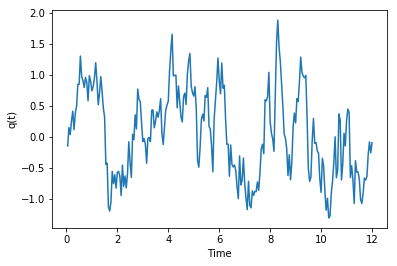

In [9]:
plt.plot(t_traj, q_traj)
plt.xlabel('Time')
plt.ylabel('q(t)')
plt.show()

Note that we can run this multiple times and it will give different-looking plots, as we're using random numbers.

Though the plot will look different, the statistics of the trajectories will be the same. We can look at these properties by considering an _ensemble_ of particles. This just means we run multiple copies in parallel, and average over them to get statistics.
Let's try plotting an ensemble of 100 trajectories, each trajectory is known as a _walker_.

In [16]:
q0 = np.zeros(100) # 100 walkers, starting at q=0.
h = 0.05 
T = 12
Nsteps = int(T/h)
q_traj, t_traj = run_simulation( q0 , Nsteps, h, 1,  EulerMaruyama, GaussianForce)

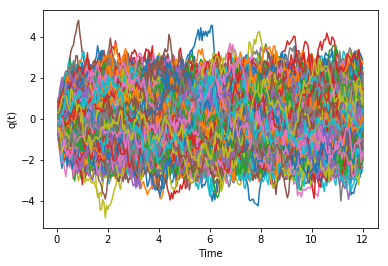

In [17]:
plt.plot(t_traj, q_traj)
plt.xlabel('Time')
plt.ylabel('q(t)')
plt.show()

This is a bit of a mess to look at.

Much more sensible is to look at how expectation values change over time. We can do this by taking the mean over the ensemble, and in the limit of infinite walkers this will tend to the correct expectation.

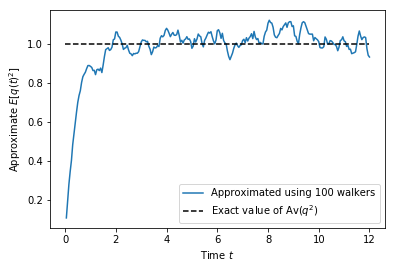

In [18]:
# Take the mean of f(q) = q^2 over the ensemble:
ensemble_mean = np.mean( q_traj**2,1)

# Show how this ensemble mean changes with time
plt.plot( t_traj, ensemble_mean, label='Approximated using 100 walkers' )

# We also plot the value of Av(q^2)
plt.plot( [0,12], [exact_average_q2,exact_average_q2],'--k',label='Exact value of Av($q^2)$')

plt.legend()
plt.xlabel('Time $t$')
plt.ylabel('Approximate $E[q(t)^2]$') 
plt.show()

Here we have approximated $\mathbf{E}[ q(t)^2]$ using our ensemble of 100 walkers. Like any approximated expectation, it gets better if we average over more datapoints.

**[2] Plot the value of **$\mathbf{E}[q(t)^2]$** for **$h=0.05$** and **$T=12$**, approximated using 100, 1000 and 10000 walkers.**

_(Plot the three curves on the same axis. Axis labels and a legend will be expected to be included.)_

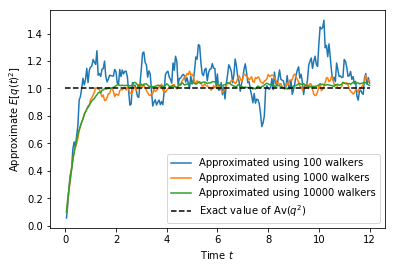

In [19]:
h = 0.05
T = 12
Nsteps = int(np.round(T/h))

q0 = np.zeros(100) # 100 walkers, starting at q=0.
q0_1000 = np.zeros(1000)
q0_10000 = np.zeros(10000)

h = 0.05 
T = 12
Nsteps = int(T/h)

q_traj, t_traj = run_simulation( q0 , Nsteps, h, 1,  EulerMaruyama, GaussianForce)
q_traj1000, t_traj1000 = run_simulation( q0_1000 , Nsteps, h, 1,  EulerMaruyama, GaussianForce)
q_traj10000, t_traj10000 = run_simulation( q0_10000 , Nsteps, h, 1,  EulerMaruyama, GaussianForce)

# Take the mean of f(q) = q^2 over the ensemble:
ensemble_mean = np.mean( q_traj**2,1)
ensemble_mean1000 = np.mean( q_traj1000**2,1)
ensemble_mean10000 = np.mean( q_traj10000**2,1)


# Show how this ensemble mean changes with time
plt.plot( t_traj, ensemble_mean, label='Approximated using 100 walkers' )
plt.plot( t_traj, ensemble_mean1000, label='Approximated using 1000 walkers' )
plt.plot( t_traj, ensemble_mean10000, label='Approximated using 10000 walkers' )

# We also plot the value of Av(q^2)
plt.plot( [0,12], [exact_average_q2,exact_average_q2],'--k',label='Exact value of Av($q^2)$')

plt.legend()
plt.xlabel('Time $t$')
plt.ylabel('Approximate $E[q(t)^2]$') 
plt.show()

You should see that the expectation 'settles down' as you average over more walkers. Also as $t\to\infty$ we have $\mathbf{E}[q(t)^2]\to\rm{Av}(q^2)$, with the error becoming very small even at modest values of $t$.

As well as looking at the evolution of expectations, we can also look at the evolution of the distribution of the points themselves. At large times $t$, the distribution of $q(t)$ should tend to the target distribution $\rho_\beta(q)$. We can check that in our simulation:

In [28]:
# Run a simulation with 10000 walkers
q0 = np.zeros(10000)
h = 0.05
T = 5
Nsteps = int(T/h)
q_traj, t_traj = run_simulation( q0 , Nsteps, h, 1,  EulerMaruyama, GaussianForce)

We can then plot a histogram of the ensemble at the end point of our trajectory, and compare it to the target distribution. Using `density=True` will normalize the histogram for us in the plot.

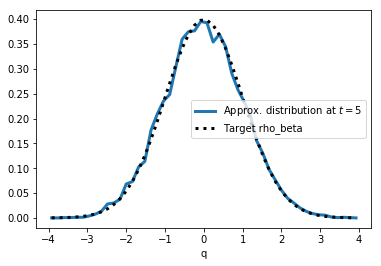

In [32]:
# Look at the distribution at the end point in time 
hgram,bins = np.histogram( q_traj[-1,:],range=[-4,4],bins=50,density=True )
midx = (bins[1:]+bins[:-1])/2  # Get the midpoints of the bin edges
plt.plot(midx, hgram, linewidth=3,label='Approx. distribution at $t=5$')

Z_beta = np.sqrt(2*np.pi)  # We know this value for a Gaussian!
rho_beta = np.exp(- midx**2 /2 ) / Z_beta
plt.plot(midx,rho_beta,':k',linewidth=3,label='Target rho_beta')
plt.legend()
plt.xlabel('q')
plt.show()


We can see they line up really well! If you add more walkers then you should see the approximate histogram will get even smoother.

This is what the distribution of ensemble points looks like at the end of the simulation, what about throughout the simulation?

**[3] Plot the evolving distribution of **$q(t)$** at times **$t\in\{0.05,0.1,0.2,2\}$**, from a simulation with **$h=0.05$** and 10000 walkers.**

_(Plot the curves on the same axis. Axis labels and a legend will be expected to be included.)_

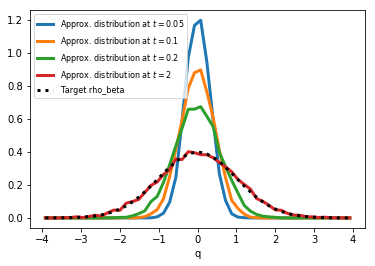

In [40]:
# Look at the distribution at different times
hgram,bins = np.histogram( q_traj[0,:],range=[-4,4],bins=50,density=True )
midx = (bins[1:]+bins[:-1])/2  # Get the midpoints of the bin edges
plt.plot(midx, hgram, linewidth=3,label='Approx. distribution at $t=0.05$')

# t=0.1
hgram1,bins1 = np.histogram( q_traj[1,:],range=[-4,4],bins=50,density=True )
midx1 = (bins1[1:]+bins1[:-1])/2  # Get the midpoints of the bin edges
plt.plot(midx1, hgram1, linewidth=3,label='Approx. distribution at $t=0.1$')

# t=0.2
hgram2,bins2 = np.histogram( q_traj[3,:],range=[-4,4],bins=50,density=True )
midx2 = (bins2[1:]+bins2[:-1])/2  # Get the midpoints of the bin edges
plt.plot(midx2, hgram2, linewidth=3,label='Approx. distribution at $t=0.2$')

# t=2
hgram3,bins3 = np.histogram( q_traj[39,:],range=[-4,4],bins=50,density=True )
midx3 = (bins3[1:]+bins3[:-1])/2  # Get the midpoints of the bin edges
plt.plot(midx3, hgram3, linewidth=3,label='Approx. distribution at $t=2$')

Z_beta = np.sqrt(2*np.pi)  # We know this value for a Gaussian!
rho_beta = np.exp(- midx**2 /2 ) / Z_beta
plt.plot(midx,rho_beta,':k',linewidth=3,label='Target rho_beta')
plt.legend(loc=2, prop={'size': 8})
plt.xlabel('q')
plt.show()


You should see that at short times the distribution of $q(t)$ is nowhere near the target distribution, so the target averages will be poor.

But if all we care about is the expectation at large $t$, why not increase the stepsize $h$ so we do less work (i.e. `Nsteps` is smaller)?

We will denote by $\hat{q}_h(t)$ a trajectory generated using our numerical method using a stepsize $h$, at time $t$. We can ask how $\mathbf{E}[\hat{q}_h(t)]$ compared to the true evolution $\mathbf{E}[q(t)]$.

**[4] Plot the evolution of **$\mathbf{E}[\hat{q}_h(t)^2]$**, computed from simulations with **$T=4$** and using stepsizes **$h\in\{0.05,0.1,0.2,0.4,0.8\}$.

_(Plot the curves on the same axis. Axis labels and a legend will be expected to be included. You should use enough walkers so that the curves do not appear noisy: 100000 should be fine.)_

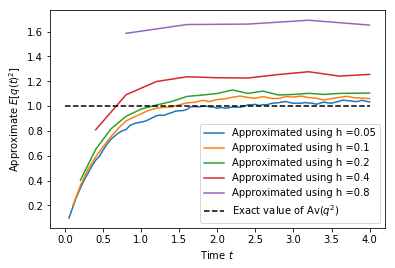

In [50]:
q0 = np.zeros(10000)
h = [0.05,0.1,0.2,0.4,0.8]
T = 4

for step in h:
    Nsteps = int(T/step)
    q_traj, t_traj = run_simulation( q0 , Nsteps, step, 1,  EulerMaruyama, GaussianForce)
    ensemble_mean = np.mean( q_traj**2,1)
    legend = 'Approximated using h =' + str(step)
    plt.plot( t_traj, ensemble_mean, label= legend)

plt.plot( [0,4], [exact_average_q2,exact_average_q2],'--k',label='Exact value of Av($q^2)$')

plt.legend()
plt.xlabel('Time $t$')
plt.ylabel('Approximate $E[q(t)^2]$') 
plt.show()

You should see that the results for larger $h$ give a bigger error, although we get these results faster as we have to do fewer steps. (Optional: What happens if you try larger stepsizes? Does it always converge?) The Euler method is known to be first order accurate for long-time sampling, which means that the error 

$$ \left|\mathbf{E}[ f(q(T)) ] - \rm{Av}_{\rho_\beta}(f(q))\right| = O(h) $$

for large $T$. We have seen in the plot for Q4 that at $T=4$ we have essentially converged to the correct average, so we can look at the error we make at that time.

**[5] Using **$10^6$** walkers, with **$T=4$**, compute the value of **$\mathbf{E}[\hat{q}_h(T)^2]$** for **$h\in\{0.025,0.05,0.1,0.2\}$**, and show that the error (defined above) changes linearly with stepsize, using a `loglog` plot.**

_(Axis labels and a legend will be expected to be included. You should include an $O(h)$ guideline to show that the error follows that behaviour: i.e. add `plt.plot([0.025,0.05,0.1,0.2],[0.025,0.05,0.1,0.2])`)_


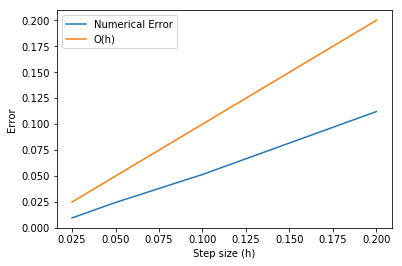

In [65]:
q0 = np.zeros(int(1e6))
h = [0.025,0.05,0.1,0.2]
T = 4
error = np.zeros(len(h))
itr = 0
for step in h:
    Nsteps = int(T/step)
    q_traj, t_traj = run_simulation( q0 , Nsteps, step, 1,  EulerMaruyama, GaussianForce)
    ensemble_mean = np.mean( q_traj[-1,:]**2)
    error[itr] = abs(ensemble_mean - exact_average_q2) 
    itr = itr+1
    
plt.plot( h,error,label ='Numerical Error')

plt.plot([0.025,0.05,0.1,0.2],[0.025,0.05,0.1,0.2],label='O(h)')
plt.legend()
plt.xlabel('Step size (h)')
plt.ylabel('Error') 
plt.show()

Just as interesting as the long-time distribution is the evolution of the average at short time. This is the so-called _weak_ evolution of the system, with the weak error at time $t$ defined as 

$$ {\text{Weak error at time }}t = \left| \mathbf{E}[ f(\hat{q}_h(t))] - \mathbf{E}[ f(q(t))]\right|$$

If $U(q)=q^2/2$, then you are given that $\mathbf{E}[q(t)^2] = 1 - \exp(-2t)$. _(Optional: This can be shown via Ito's lemma.)_

**[6] Using **$h\in\{0.025,0.05,0.1,0.2\}$**, show that the weak error at $t=0.6$ changes linearly with stepsize, using a `loglog` plot. In other words, show that Euler-Maruyama is a weak first order method.**

_(Axis labels and a legend will be expected to be included. You should include an $O(h)$ guideline to show that the error follows that behaviour: i.e. add `plt.plot([0.025,0.05,0.1,0.2],[0.025,0.05,0.1,0.2])`)_



We can look at using other numerical methods instead of Euler-Maruyama. One example is the LM method:

$$ \left| \begin{array}{rcl} 
R(t+h)&\leftarrow&\text{Normal}(0,1)\\
\qquad q(t+h)&\leftarrow&q(t) + h\, F(q(t)) + \frac12 \sqrt{2 h / \beta}\left( R(t) + R(t+h) \right)
\end{array}\right.$$

Note that this still only requires one evaluation of $F$ per step, with $F$ usually being the computationally expensive part.

**[7] Code a version of the LM method below.**

In [ ]:
def LM(q, R, h, force, beta): 
    
    # [!] Your code here
    
    return q_t, R_t

This LM function can be swapped in place of the EulerMaruyama function in `run_simulation` in order to be used.

**[8] Repeat Q5 and Q6 using the LM method instead of Euler-Maruyama.**

You should see that at small times (i.e. the results of Q6) you still have a first-order error, but at long times (i.e. results from Q5) there is no discernable trend. Conceptually it may help to plot the evolution of the expectation for the LM method, as you did in Q4.

What is actually happening is that the LM scheme is _exact_ for Gaussians in the long time, but only first order in the short time. This is a special case for Gaussian distributions - for more general $U(q)$ functions, LM is $O(h^2)$ in long time, and $O(h)$ in short time.

***

### The double-well example

The normal distribution is an important test case, but we can apply out schemes to more complicated potential energy functions where we cannot solve to find things exactly.

We shall look at the _double-well_ potential energy, defined here as 

$$U(q) = 2(q^2-1)^2$$

Note that this has two minima, at $q=\pm1$. We can plot the form of the distribution by plotting $\exp(-\beta U(q))$. Note that this isn't the distribution itself, as we haven't normalised it by $Z_\beta$. In fact, for an example even as simple as this, we cannot exactly evaluate $Z_\beta$ !.

In [ ]:
beta = 1 
q_span = np.linspace(-3,3,100)
Uq = 2*(q_span**2-1)**2
rho = np.exp(- beta * Uq ) 
plt.plot( q_span, rho)
plt.xlabel('q')
plt.title('$\exp(-U(q))$')
plt.show()

So the distribution has two large clusters centred around the minima. We can simulate this using the LM method as before.

**[9] Code the force routine for the double-well potential below.**

In [ ]:
def DoubleWellForce(q):
    
    # U(q) = 2(q^2-1)^2
    
    f = ? # [!]
    
    return f

In [ ]:
# You can check here
q0=1.1
print( DoubleWellForce(q0) )
# Should output -1.848  

We can initialise 10 walkers at $q=1.1$ and see how they evolve.

In [ ]:
q0 = 1.1*np.ones(10)  # Initialise 10 walkers around 1.1
h = 0.05
T = 10
Nsteps = int(np.round(T/h))
q_traj, t_traj = run_simulation( q0 , Nsteps, h, 1,  LM, DoubleWellForce)

In [ ]:
plt.plot( t_traj, q_traj )
plt.show()

You should see that most of the walkers stay close to $q=1$, and by the end of the simulation some walkers have jumped over to the other well. This is an example of how barriers, like the one at $q=0$, can prevent a quick exploration of the surface. You can imagine in high-dimensions, for complicated $U(q)$, it can take a long time to pass over barriers you don't even know exist.

**[10] Like in Q4, plot the evolving distribution of **$q(t)$** in this example at times **$t\in\{0.1,0.5,2.5,10\}$**, from a simulation with **$h=0.05$** and 10000 walkers.**

_(Plot the curves on the same axis. Axis labels and a legend will be expected to be included.)_

You should see the distribution slowly spill into the other well. (Optional: Animate the evolution of the distribution).

You can plot the distribution by making a histogram with the `density=True` flag, like in Q4. Parameters `range=[-2.5,2.5]` and `bins=50` give good results. You may wish to use more walkers to get a smoother histogram.

In [ ]:
q0 = 1.1*np.ones(10000)  # Initialise 10000 walkers around 1.1
h = 0.05


**Optional:**
1. For the Gaussian example, at what stepsize $h$ does the average no longer converge as $T$ increases? Is this also true in the LM method? You may wish to show this analytically.
2. Compute the average time for a barrier crossing (i.e. a sign flip) in the double-well example. What happens if you increase/decrease the beta parameter? Find a relation between the crossing time as a function of beta.
3. Run Q5/6/8 for the double-well example to show the error relation as a function of stepsize.
4. Run a simulation using the 2D spring potential that we used in week 1, and plot a 2D histogram of the evolving distribution.